In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


from option_chain import OptionChain
from dataclasses import fields, replace, asdict
from datetime import datetime, timedelta
from test_option_chain import get_gld_test_chain_data_6m, get_sqqq_test_chain_data, get_spy_test_chain_data

from bsm_pricer import compute_bsm_price


import warnings
warnings.filterwarnings('ignore')

In [19]:
DAYS_PER_YEAR = 365
HOURS_PER_YEAR = 365 * 24
SECONDS_PER_YEAR = 365 * 24 * 60 * 60  # minute, seconds

In [20]:
# options_BTC = pd.read_csv('../../resources/options_BTC.csv')

options_BTC = pd.read_feather('BTC_freq_D_hour_8.feather')

options_BTC = options_BTC.drop_duplicates(subset=['index', 'contract'], keep='last')
options_BTC.loc[:,'date'] = options_BTC.loc[:,'index'].copy()

options_BTC.loc[:,'datetime'] = pd.to_datetime(options_BTC.loc[:,'index'])
options_BTC.loc[:,'datetime'] = options_BTC.loc[:,'datetime'].apply(lambda x:x.replace(tzinfo=None))

options_BTC.loc[:,'strike'] = options_BTC.contract.apply(lambda x:x.split('-')[3])
options_BTC.loc[:,'option_type'] = options_BTC.contract.apply(lambda x:x.split('-')[4])
options_BTC.loc[:,'forward'] = options_BTC.underlying_price
options_BTC.loc[:,'maturity'] = options_BTC.contract.apply(lambda x:x.split('-')[2])
options_BTC.strike = options_BTC.strike.apply(np.float)
options_BTC.forward = options_BTC.forward.apply(np.float)

# Daily options expire every day at 08:00 UTC. Weekly options expire on each Friday of each week at 08:00 UTC. Monthly options expire on the last Friday of each calendar month at 08:00 UTC. Quarterly options expire on the last Friday of each calendar quarter at 08:00 UTC.
# https://www.deribit.com/kb/deribit-introduction-policy
options_BTC.maturity = pd.to_datetime(options_BTC.maturity)


options_BTC.maturity += timedelta(hours=8)
options_BTC.loc[:,'ttm'] = (options_BTC.maturity - options_BTC.datetime)
options_BTC.ttm = options_BTC.ttm.apply(lambda x: x.total_seconds()/SECONDS_PER_YEAR)

options_BTC.loc[:,'ids'] = options_BTC.ttm*365
options_BTC.loc[:,'ids'] = options_BTC.loc[:,'ids'].apply(int)

# remove bad quotes
options_BTC = options_BTC.loc[options_BTC.ask_iv != 0,:]
options_BTC = options_BTC.loc[options_BTC.ask_iv < 5,:]

options_BTC = options_BTC.loc[options_BTC.bid_iv != 0,:]
options_BTC = options_BTC.loc[options_BTC.bid_iv < 5,:]


# remove large bid-ask spread
options_BTC.loc[:, 'bid_ask_spread'] = options_BTC.ask_iv - options_BTC.bid_iv
_id =  options_BTC.bid_ask_spread < 0.1
options_BTC = options_BTC.loc[_id,:]

# Drop duplicated call and put iv at same strike, keep the smaller spread one
options_BTC = options_BTC.sort_values('bid_ask_spread')
options_BTC = options_BTC.drop_duplicates(['strike', 'date', 'ids'],keep='first')
options_BTC = options_BTC.sort_values('strike')




In [21]:
date = '2022-07-15 08:00:00+00:00'

to_study = options_BTC.query('date == @date')
ids = np.unique(to_study.ids)
print(ids)
# to_study = to_study.loc[to_study.ids.apply(lambda x: x in [7,14,21, 42, 77, 168]),:]
ids = np.unique(to_study.ids)
ticker = 'BTC'
ttms = np.unique(to_study.ttm)
forwards = []
discfactors = []
bid_ivs = []
ask_ivs = []
strikes_ttms = []
optiontypes_ttms = []

for _ids in ids:
    forwards.append(np.mean(to_study.loc[to_study.ids == _ids,:].forward))
    discfactors.append(1)
    bid_ivs.append(np.array((to_study.loc[to_study.ids == _ids,:].bid_iv)))
    ask_ivs.append(np.array((to_study.loc[to_study.ids == _ids,:].ask_iv)))
    strikes_ttms.append(np.array(to_study.loc[to_study.ids == _ids,:].strike))
    optiontypes_ttms.append(np.array(to_study.loc[to_study.ids == _ids,:].option_type, dtype='<U1'))
    
    
BTC_option_chain = OptionChain(ids=ids,
                    ttms=ttms,
                    ticker=ticker,
                    forwards=forwards,
                    strikes_ttms=strikes_ttms,
                    optiontypes_ttms=optiontypes_ttms,
                    discfactors=discfactors,
                    bid_ivs=bid_ivs,
                    ask_ivs=ask_ivs)

[  1   2   7  14  21  42  77 168 259 350]


[0.00273973 0.00547945 0.01917808 0.03835616 0.05753425 0.11506849
 0.2109589  0.46027397 0.70958904 0.95890411]


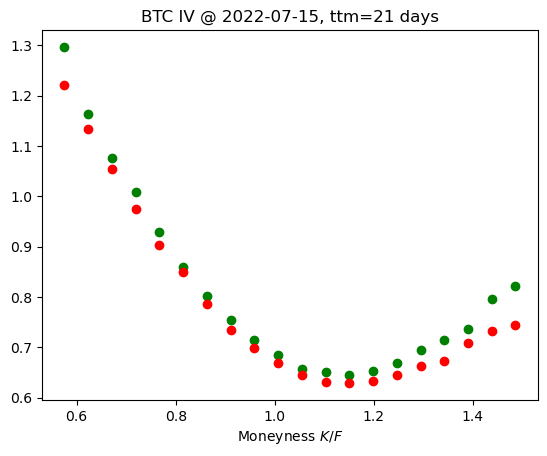

In [37]:
date = '2022-07-15 08:00:00+00:00'
to_plot = options_BTC.query('date == @date')
ttm_arr = np.unique(to_plot.ttm)
ttm = ttm_arr[4]
print(ttm_arr)
to_plot = options_BTC.query('date == @date and ttm == @ttm')

M = to_plot.strike/to_plot.forward
log_M = np.log(M)

plt.scatter(M, to_plot.ask_iv, c='green')
plt.scatter(M, to_plot.bid_iv, c='red')
plt.xlabel(r'Moneyness $K/F$')

plt.title('BTC IV @ 2022-07-15, ttm=%i days'%int(ttm*365) )
plt.savefig('IV_BTC_20220715_%sdays.png'%int(ttm*365), transparent=True)

[0.00273973 0.00547945 0.01917808 0.03835616 0.05753425 0.11506849
 0.2109589  0.46027397 0.70958904 0.95890411]


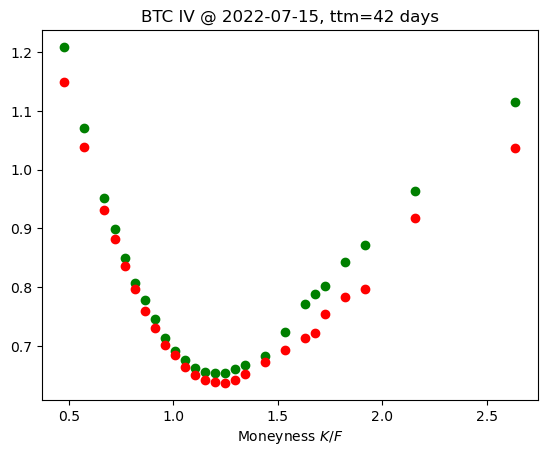

In [36]:
date = '2022-07-15 08:00:00+00:00'
to_plot = options_BTC.query('date == @date')
ttm_arr = np.unique(to_plot.ttm)
ttm = ttm_arr[5]
print(ttm_arr)
to_plot = options_BTC.query('date == @date and ttm == @ttm')

M = to_plot.strike/to_plot.forward
log_M = np.log(M)

plt.scatter(M, to_plot.ask_iv, c='green')
plt.scatter(M, to_plot.bid_iv, c='red')
plt.xlabel(r'Moneyness $K/F$')

plt.title('BTC IV @ 2022-07-15, ttm=%i days'%int(ttm*365) )
plt.savefig('IV_BTC_20220715_%sdays.png'%int(ttm*365), transparent=True)

In [22]:
def Backus_option_price(r, F, K, tau, I, 
                        sigma_tau, gamma_1_tau, gamma_2_tau):
    # Backus et al (2004) 
    # r: risk-free
    # F: Forward price
    # K: Strike
    # tau: time to maturity (in years)
    # I: 1 for call, 0 for put
    # sigma_tau: standard deviation of tau-period log returns
    # gamma_1_tau: degree of skewness of tau-period log returns
    # gamma_2_tau: excess-kurtosis of tau-period log returns

    # sigma_tau = sigma * np.sqrt(tau)
    d = (np.log(F/K)+sigma_tau**2/2) / sigma_tau
    part1 = np.exp(-r*tau)*( F*norm.cdf(d) - K*norm.cdf(d-sigma_tau) )
    part2 = F*np.exp(-r*tau)*norm.pdf(d)*sigma_tau
    part3 = gamma_1_tau*(2*sigma_tau-d)/np.math.factorial(3) - gamma_2_tau*(1-d**2+3*d*sigma_tau - 3*sigma_tau**2)/np.math.factorial(4)

    P = part1+part2*part3 - np.exp(-r*tau)*(F-K) # Put price
    return P + I*np.exp(-r*tau)*(F-K)


In [23]:
BTC_skew_kurt_loss = []


option_chain = BTC_option_chain 
# option_chain =  get_gld_test_chain_data_6m()

# , get_sqqq_test_chain_data, get_spy_test_chain_data

i_arr = range(len(option_chain.ttms))
# i_arr = [6]
for i in i_arr:
    tau = option_chain.ttms[i]
    F = option_chain.forwards[i]
    K_ttm = option_chain.strikes_ttms[i]
    option_type_ttm = option_chain.optiontypes_ttms[i]
    I_ttm = (option_type_ttm == 'C') * 1

    mid_ivs = ( option_chain.bid_ivs[i] + option_chain.ask_ivs[i] )/ 2

    mid_prices = [compute_bsm_price(forward=F, strike=K_ttm[j], ttm=tau , vol=mid_ivs[j], optiontype=option_type_ttm[j]) for j in range(len(K_ttm))]
    mid_prices = np.array(mid_prices)


    def objective(pars):
        sigma_tau, gamma_1_tau, gamma_2_tau = pars
        Backus_option_price_arr = Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        sigma_tau, gamma_1_tau, gamma_2_tau)
        loss = np.mean( np.abs( (np.array(Backus_option_price_arr) - mid_prices)/mid_prices)  )
        # print(pars, loss)
        return loss


    p0 = (0.5,0,0)
    results = minimize(objective, p0, method='powell')

    sigma_tau, gamma_1_tau, gamma_2_tau = results.x
    loss = objective(results.x)
    # plt.plot(F/K_ttm, Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        # sigma_tau, gamma_1_tau, gamma_2_tau) )

    # plt.plot(F/K_ttm, mid_prices)
    BTC_skew_kurt_loss.append(np.concatenate([np.array([tau]), results.x, np.array([loss])]).flatten())

BTC_skew_kurt_loss = pd.DataFrame(BTC_skew_kurt_loss)
BTC_skew_kurt_loss.columns = ['tau','sigma_tau', 'gamma_1_tau', 'gamma_2_tau', 'loss']
BTC_skew_kurt_loss

,tau,sigma_tau,gamma_1_tau,gamma_2_tau,loss
0,0.002740,0.035154,0.268261,0.003534,0.011839
1,0.005479,0.047485,-0.128630,0.894670,0.015013
2,0.019178,0.094899,-0.547061,1.765210,0.094416
3,0.038356,0.151396,-0.794012,2.217781,0.109553
4,0.057534,0.186067,-0.903252,2.102222,0.093741
5,0.115068,0.273075,-0.950090,1.997083,0.087705
6,0.210959,0.389873,-1.041999,2.094623,0.093607
7,0.460274,0.608407,-1.023205,1.678059,0.084628
8,0.709589,0.737220,-0.871822,1.342008,0.048807
9,0.958904,0.711561,-0.149157,0.383416,0.083690


In [24]:
GLD_skew_kurt_loss = []

# option_chain = BTC_option_chain 
option_chain =  get_gld_test_chain_data_6m()

# , get_sqqq_test_chain_data, get_spy_test_chain_data

i_arr = range(len(option_chain.ttms))
# i_arr = [6]
for i in i_arr:
    tau = option_chain.ttms[i]
    F = option_chain.forwards[i]
    K_ttm = option_chain.strikes_ttms[i]
    option_type_ttm = option_chain.optiontypes_ttms[i]
    I_ttm = (option_type_ttm == 'C') * 1

    mid_ivs = ( option_chain.bid_ivs[i] + option_chain.ask_ivs[i] )/ 2

    mid_prices = [compute_bsm_price(forward=F, strike=K_ttm[j], ttm=tau , vol=mid_ivs[j], optiontype=option_type_ttm[j]) for j in range(len(K_ttm))]
    mid_prices = np.array(mid_prices)


    def objective(pars):
        sigma_tau, gamma_1_tau, gamma_2_tau = pars
        Backus_option_price_arr = Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        sigma_tau, gamma_1_tau, gamma_2_tau)
        loss = np.mean( np.abs( (np.array(Backus_option_price_arr) - mid_prices)/mid_prices)  )
        # print(pars, loss)
        return loss


    p0 = (0.5,0,0)
    results = minimize(objective, p0, method='powell')

    sigma_tau, gamma_1_tau, gamma_2_tau = results.x
    loss = objective(results.x)
    # plt.plot(F/K_ttm, Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        # sigma_tau, gamma_1_tau, gamma_2_tau) )

    # plt.plot(F/K_ttm, mid_prices)
    GLD_skew_kurt_loss.append(np.concatenate([np.array([tau]), results.x, np.array([loss])]).flatten())

GLD_skew_kurt_loss = pd.DataFrame(GLD_skew_kurt_loss)
GLD_skew_kurt_loss.columns = ['tau','sigma_tau', 'gamma_1_tau', 'gamma_2_tau', 'loss']
GLD_skew_kurt_loss

,tau,sigma_tau,gamma_1_tau,gamma_2_tau,loss
0,0.056437,0.043990,-0.291808,1.661549,0.010572
1,0.095326,0.056762,-0.248721,1.821473,0.011420
2,0.173104,0.077269,-0.125316,2.018973,0.008601
3,0.425882,0.130271,0.006993,2.110800,0.011546


In [25]:
SQQQ_skew_kurt_loss = []

# option_chain = BTC_option_chain 
option_chain =  get_sqqq_test_chain_data()

# , get_sqqq_test_chain_data, get_spy_test_chain_data

i_arr = range(len(option_chain.ttms))
# i_arr = [6]
for i in i_arr:
    tau = option_chain.ttms[i]
    F = option_chain.forwards[i]
    K_ttm = option_chain.strikes_ttms[i]
    option_type_ttm = option_chain.optiontypes_ttms[i]
    I_ttm = (option_type_ttm == 'C') * 1

    mid_ivs = ( option_chain.bid_ivs[i] + option_chain.ask_ivs[i] )/ 2

    mid_prices = [compute_bsm_price(forward=F, strike=K_ttm[j], ttm=tau , vol=mid_ivs[j], optiontype=option_type_ttm[j]) for j in range(len(K_ttm))]
    mid_prices = np.array(mid_prices)


    def objective(pars):
        sigma_tau, gamma_1_tau, gamma_2_tau = pars
        Backus_option_price_arr = Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        sigma_tau, gamma_1_tau, gamma_2_tau)
        loss = np.mean( np.abs( (np.array(Backus_option_price_arr) - mid_prices)/mid_prices)  )
        # print(pars, loss)
        return loss


    p0 = (0.5,0,0)
    results = minimize(objective, p0, method='powell')

    sigma_tau, gamma_1_tau, gamma_2_tau = results.x
    loss = objective(results.x)
    # plt.plot(F/K_ttm, Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        # sigma_tau, gamma_1_tau, gamma_2_tau) )

    # plt.plot(F/K_ttm, mid_prices)
    SQQQ_skew_kurt_loss.append(np.concatenate([np.array([tau]), results.x, np.array([loss])]).flatten())

SQQQ_skew_kurt_loss = pd.DataFrame(SQQQ_skew_kurt_loss)
SQQQ_skew_kurt_loss.columns = ['tau','sigma_tau', 'gamma_1_tau', 'gamma_2_tau', 'loss']
SQQQ_skew_kurt_loss

,tau,sigma_tau,gamma_1_tau,gamma_2_tau,loss
0,0.056437,0.220798,0.665315,0.387491,0.021349
1,0.095326,0.295272,0.284332,1.370402,0.036988
2,0.173104,0.359018,0.979726,1.031480,0.022329
3,0.425882,0.551526,1.030269,0.797823,0.034184


In [26]:
SPY_skew_kurt_loss = []

# option_chain = BTC_option_chain 
option_chain =  get_spy_test_chain_data()

# , get_sqqq_test_chain_data, get_spy_test_chain_data

i_arr = range(len(option_chain.ttms))
# i_arr = [6]
for i in i_arr:
    tau = option_chain.ttms[i]
    F = option_chain.forwards[i]
    K_ttm = option_chain.strikes_ttms[i]
    option_type_ttm = option_chain.optiontypes_ttms[i]
    I_ttm = (option_type_ttm == 'C') * 1

    mid_ivs = ( option_chain.bid_ivs[i] + option_chain.ask_ivs[i] )/ 2

    mid_prices = [compute_bsm_price(forward=F, strike=K_ttm[j], ttm=tau , vol=mid_ivs[j], optiontype=option_type_ttm[j]) for j in range(len(K_ttm))]
    mid_prices = np.array(mid_prices)


    def objective(pars):
        sigma_tau, gamma_1_tau, gamma_2_tau = pars
        Backus_option_price_arr = Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        sigma_tau, gamma_1_tau, gamma_2_tau)
        loss = np.mean( np.abs( (np.array(Backus_option_price_arr) - mid_prices)/mid_prices)  )
        # print(pars, loss)
        return loss


    p0 = (0.5,0,0)
    results = minimize(objective, p0, method='powell')

    sigma_tau, gamma_1_tau, gamma_2_tau = results.x
    loss = objective(results.x)
    # plt.plot(F/K_ttm, Backus_option_price(0, F, K_ttm, tau, I_ttm, 
                        # sigma_tau, gamma_1_tau, gamma_2_tau) )

    # plt.plot(F/K_ttm, mid_prices)
    SPY_skew_kurt_loss.append(np.concatenate([np.array([tau]), results.x, np.array([loss])]).flatten())

SPY_skew_kurt_loss = pd.DataFrame(SPY_skew_kurt_loss)
SPY_skew_kurt_loss.columns = ['tau','sigma_tau', 'gamma_1_tau', 'gamma_2_tau', 'loss']
SPY_skew_kurt_loss

,tau,sigma_tau,gamma_1_tau,gamma_2_tau,loss
0,0.056437,0.057274,-0.940764,0.432231,0.033190
1,0.095326,0.074098,-1.039576,1.135956,0.045591
2,0.173104,0.104248,-1.167732,1.467504,0.055984
3,0.425882,0.177988,-1.451592,2.349057,0.059045


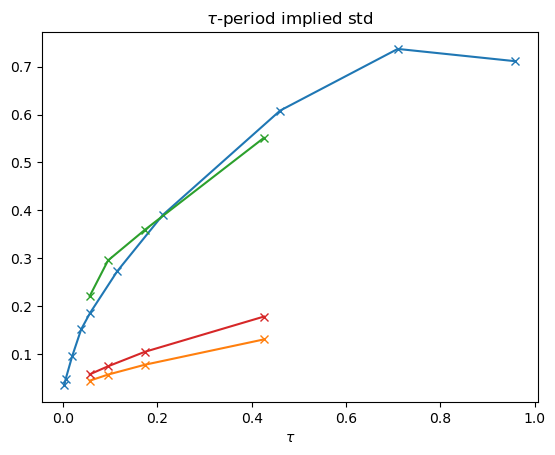

In [27]:
df = BTC_skew_kurt_loss
plt.plot(df.tau, df.sigma_tau, label='BTC', marker='x')

df = GLD_skew_kurt_loss
plt.plot(df.tau, df.sigma_tau, label='GLD', marker='x')

df = SQQQ_skew_kurt_loss
plt.plot(df.tau, df.sigma_tau, label='SQQQ', marker='x')

df = SPY_skew_kurt_loss
plt.plot(df.tau, df.sigma_tau, label='SPY', marker='x')


# tau_arr = np.linspace(BTC_skew_kurt_loss.tau.min(),BTC_skew_kurt_loss.tau.max())
# sigma_tau_arr = 0.1*np.sqrt(tau_arr)
# plt.plot(tau_arr, sigma_tau_arr)

# plt.legend()
plt.title(r'$\tau$-period implied std')
plt.xlabel(r'$\tau$')
plt.savefig('sigma_tau.png', transparent=True)



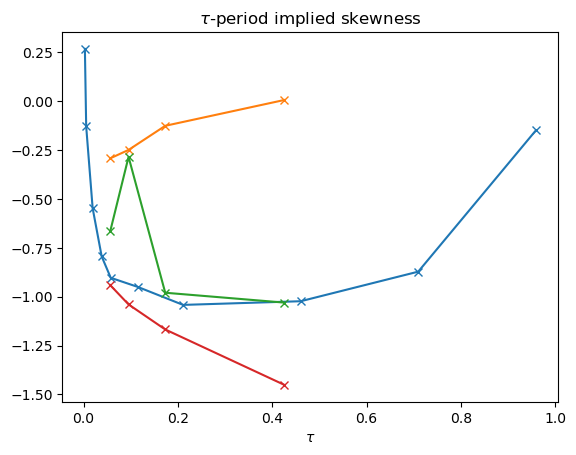

In [28]:
df = BTC_skew_kurt_loss
plt.plot(df.tau, df.gamma_1_tau, label='BTC', marker='x')

df = GLD_skew_kurt_loss
plt.plot(df.tau, df.gamma_1_tau, label='GLD', marker='x')

df = SQQQ_skew_kurt_loss
plt.plot(df.tau, -df.gamma_1_tau, label='SQQQ', marker='x')

df = SPY_skew_kurt_loss
plt.plot(df.tau, df.gamma_1_tau, label='SPY', marker='x')

plt.title(r'$\tau$-period implied skewness')
plt.xlabel(r'$\tau$')
plt.savefig('gamma_1_tau.png', transparent=True)



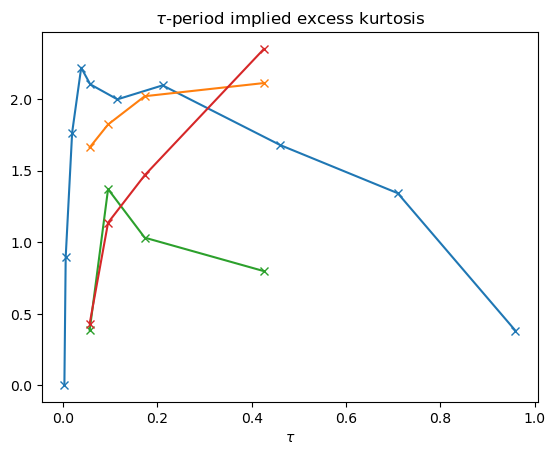

In [29]:
df = BTC_skew_kurt_loss
plt.plot(df.tau, df.gamma_2_tau, label='BTC', marker='x')

df = GLD_skew_kurt_loss
plt.plot(df.tau, df.gamma_2_tau, label='GLD', marker='x')

df = SQQQ_skew_kurt_loss
plt.plot(df.tau, df.gamma_2_tau, label='SQQQ', marker='x')

df = SPY_skew_kurt_loss
plt.plot(df.tau, df.gamma_2_tau, label='SPY', marker='x')

plt.title(r'$\tau$-period implied excess kurtosis')
plt.xlabel(r'$\tau$')
plt.savefig('gamma_2_tau.png', transparent=True)


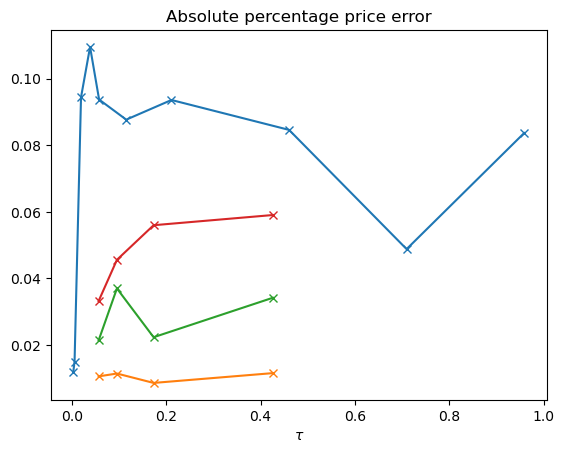

In [30]:
df = BTC_skew_kurt_loss
plt.plot(df.tau, df.loss, label='BTC', marker='x')

df = GLD_skew_kurt_loss
plt.plot(df.tau, df.loss, label='GLD', marker='x')

df = SQQQ_skew_kurt_loss
plt.plot(df.tau, df.loss, label='SQQQ', marker='x')

df = SPY_skew_kurt_loss
plt.plot(df.tau, df.loss, label='SPY', marker='x')

plt.title(r'Absolute percentage price error')
plt.xlabel(r'$\tau$')
plt.savefig('APPE.png', transparent=True)